#### This Workshop provides an example of how to load an face image dataset using tf.data in TensorFlow2.0

#### The dataset used in this example is distributed as directories of images, with one class of image per directory.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install -q tensorflow==2.0.0-beta1
import tensorflow as tf

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

#### Download and inspect the dataset

#### Retrieve the images

In [3]:
import pathlib
data_root_orig = tf.keras.utils.get_file(origin= 'https://storage.googleapis.com/iorecap19workshop/images.tar.gz',
                                         fname='images_fer2013', untar=True)
data_root = pathlib.Path(data_root_orig)
print(data_root)

/home/jupyter/.keras/datasets/images_fer2013


#### After downloading 45MB, you should now have a copy of the facial emotions photos available:

In [4]:
for item in data_root.iterdir():
  print(item)

/home/jupyter/.keras/datasets/images_fer2013/PublicTest
/home/jupyter/.keras/datasets/images_fer2013/Training
/home/jupyter/.keras/datasets/images_fer2013/PrivateTest


In [5]:
import random
all_image_paths = list(data_root.glob('*/*/*'))
print(all_image_paths)
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



35887

In [6]:
all_image_paths[:10]

['/home/jupyter/.keras/datasets/images_fer2013/Training/Surprise/26429.jpg',
 '/home/jupyter/.keras/datasets/images_fer2013/Training/Happy/27832.jpg',
 '/home/jupyter/.keras/datasets/images_fer2013/Training/Surprise/25084.jpg',
 '/home/jupyter/.keras/datasets/images_fer2013/Training/Angry/12525.jpg',
 '/home/jupyter/.keras/datasets/images_fer2013/Training/Sad/16443.jpg',
 '/home/jupyter/.keras/datasets/images_fer2013/Training/Surprise/11089.jpg',
 '/home/jupyter/.keras/datasets/images_fer2013/Training/Neutral/9016.jpg',
 '/home/jupyter/.keras/datasets/images_fer2013/Training/Angry/27740.jpg',
 '/home/jupyter/.keras/datasets/images_fer2013/Training/Disgust/21116.jpg',
 '/home/jupyter/.keras/datasets/images_fer2013/Training/Surprise/20101.jpg']

### Inspect the images

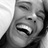

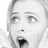

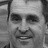

In [7]:
import IPython.display as display
for n in range(3):
  image_path = random.choice(all_image_paths)
  display.display(display.Image(image_path))
  print()

In [8]:
import os
label_names = os.listdir('/home/jupyter/.keras/datasets/images_fer2013/Training/')
print(label_names)

['Happy', 'Angry', 'Fear', 'Sad', 'Neutral', 'Surprise', 'Disgust']


In [9]:
#label_to_index = dict((name, index) for index, name in enumerate(label_names))
#label_to_index

In [27]:
expressions = {'Angry':0, 'Disgust':1, 'Fear': 2,  'Happy' : 3 , 'Sad' : 4, 'Surprise': 5, 'Neutral' : 6}
label_to_index = dict((k,v) for k, v in expressions.items())
label_to_index

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 6,
 'Sad': 4,
 'Surprise': 5}

#### Create a list of every file, and its label index:

In [11]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [5, 3, 5, 0, 4, 5, 6, 0, 1, 5]


#### Load and format the images

In [12]:
img_path = all_image_paths[0]
img_path

'/home/jupyter/.keras/datasets/images_fer2013/Training/Surprise/26429.jpg'

#### Raw Data 

In [13]:
img_raw = tf.io.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: id=1, shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x...


#### Decode it into an image tensor

In [14]:
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(48, 48, 1)
<dtype: 'uint8'>


#### Resize the images dataset for your model

In [15]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [160, 160])
  image /= 255.0  # normalize to [0,1] range

  return image

In [16]:
def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

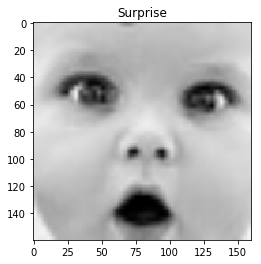

In [17]:
import matplotlib.pyplot as plt

image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(img_path))
plt.grid(False)
#plt.xlabel(caption_image(img_path))
plt.title(label_names[label].title())
print()

### Build a tf.data.Dataset

##### The easiest way to build a tf.data.Dataset is using the from_tensor_slices method.

##### Slicing the array of strings, results in a dataset of strings:

In [18]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

#### Create a new dataset that loads and formats images on the fly by mapping preprocess_image over the dataset of paths.

In [19]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

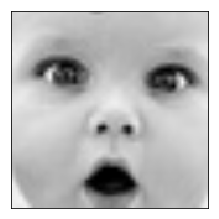

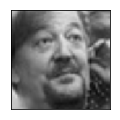

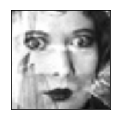

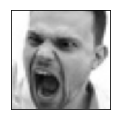

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n, image in enumerate(image_ds.take(4)):
  plt.subplot(2,2,n+1)
  plt.imshow(image)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.show()

#### A dataset of (image, label) pairs
Using the same from_tensor_slices method you can build a dataset of labels:

In [21]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

In [22]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

In [23]:
print(image_label_ds)

<ZipDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>


### Basic methods for training
#### To train a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* To repeat forever.
* Batches to be available as soon as possible.
* These features can be easily added using the tf.data api.

In [24]:
BATCH_SIZE = 32

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches in the background while the model is training.
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.int64)>

In [25]:
ds = image_label_ds.apply(
tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
#tf.data.Dataset.shuffle(buffer_size, seed)
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

W0711 15:20:17.954421 140268206532352 deprecation.py:323] From <ipython-input-25-700af6899505>:2: shuffle_and_repeat (from tensorflow.python.data.experimental.ops.shuffle_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


<PrefetchDataset shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.int64)>

### Pipe the dataset to a model

In [26]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(160, 160, 3), include_top=False)
mobile_net.trainable=False

#### We are done with tf.data workshop !!! 